In [430]:
import torch
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler
from typing import List
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy

In [431]:
train_data = pd.read_csv('../data/train_data.csv', index_col=0)

In [432]:
train_data

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
SalePrice,,,,,,,,,,,,,,,,
141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0


# Display number of unique elements in each column

In [433]:
for column in train_data.columns:
    print(f"Number of unique rows in {column}: {train_data[column].nunique()}")


Number of unique rows in YearBuilt: 16
Number of unique rows in Size(sqf): 89
Number of unique rows in Floor: 43
Number of unique rows in HallwayType: 3
Number of unique rows in HeatingType: 2
Number of unique rows in AptManageType: 2
Number of unique rows in N_Parkinglot(Ground): 23
Number of unique rows in N_Parkinglot(Basement): 20
Number of unique rows in TimeToBusStop: 3
Number of unique rows in TimeToSubway: 5
Number of unique rows in N_manager: 9
Number of unique rows in N_elevators: 13
Number of unique rows in SubwayStation: 8
Number of unique rows in N_FacilitiesInApt: 9
Number of unique rows in N_FacilitiesNearBy(Total): 11
Number of unique rows in N_SchoolNearBy(Total): 14


In [434]:
COLUMNS_TO_DUMMY = ["HeatingType","AptManageType", "HallwayType","TimeToBusStop","TimeToSubway","SubwayStation"]
OUTPUT_COLUMN = "SalePrice"

In [435]:
CRITERIUM_MAX_AVERAGE = 350000
CRITERIUM_MAX_CHEAP = 100000

In [436]:
def classify(tensor) -> torch.tensor:
    return torch.where(tensor > CRITERIUM_MAX_AVERAGE, torch.tensor(2),
                       torch.where((tensor > CRITERIUM_MAX_CHEAP) & (tensor <= CRITERIUM_MAX_AVERAGE), torch.tensor(1),
                                   torch.tensor(0)))

In [437]:
def count_unique_elements(tensor):
    unique_elements, counts = torch.unique(tensor, return_counts=True)
    for unique, count in zip(unique_elements, counts):
        print(f"Class {unique.item()}: {count.item()} occurrences")

In [438]:
class HouseDataset(data.Dataset):
    def __init__(self, path_to_csv: str, scaler = None) -> None:
        super().__init__()
        self.data = pd.read_csv(path_to_csv)
        self.scaler = scaler
        self.label = torch.tensor(self.data.iloc[:,0].values, dtype=torch.float32)
        self._prepare_data()
        self.data = torch.tensor(self.data.iloc[:,1:].values, dtype=torch.float32)
        self.size = self.data.shape[0]
    
    def __len__(self) -> int:
        return self.size
    
    def __getitem__(self, idx) -> tuple[torch.tensor, torch.tensor]:
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label
    def _to_dummy_columns(self, columns: List[str]) -> pd.DataFrame:
        dummy_columns = pd.get_dummies(self.data, columns=columns).astype(float)
        return dummy_columns
    
    def get_non_dummy_columns(self) -> List[str]:
        return [column for column in self.data.columns if column not in COLUMS_TO_DUMMY]
    
    def _scale_data(self) -> None:
        for column in self.data:
            if column not in COLUMS_TO_DUMMY or column != OUTPUT_COLUMN:
                self.data[column] = self.scaler.fit_transform(self.data[column].values.reshape(-1, 1))
        
    def _prepare_data(self) -> None:
        self.data = self._to_dummy_columns(columns=COLUMS_TO_DUMMY)
        if self.scaler:
            self._scale_data()
    
    def get_data_as_pandas(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        data = pd.DataFrame(self.data.numpy())
        labels = pd.DataFrame(self.label.numpy())
        return data, labels
        
        
        

In [439]:
path = '../data/train_data.csv'
scaler = MinMaxScaler()
train_dataset = HouseDataset(path, scaler)

In [440]:
train_data, train_labels = train_dataset.get_data_as_pandas()

In [441]:
train_labels

,0
0,141592.0
1,51327.0
2,48672.0
3,380530.0
4,78318.0
...,...
4119,570796.0
4120,307079.0
4121,357522.0
4122,312389.0


In [442]:
train_data

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.756757,0.308356,0.047619,0.155680,0.139288,0.153846,0.000000,0.444444,0.3750,0.529412,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.189189,0.205268,0.166667,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,0.235294,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.189189,0.205268,0.119048,0.112202,0.057532,0.076923,0.074074,0.222222,0.7500,0.235294,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.756757,0.872389,0.166667,0.349229,0.405753,0.307692,0.407407,0.444444,0.1875,0.411765,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.378378,0.231154,0.023810,0.199158,0.059803,0.230769,0.296296,0.222222,0.5625,0.823529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.783784,0.814260,0.547619,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,0.588235,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4120,1.000000,0.231154,0.500000,0.143058,0.302801,0.307692,0.370370,0.666667,0.4375,0.647059,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4121,0.783784,0.332879,0.452381,0.000000,0.961393,1.000000,0.592593,1.000000,0.5625,0.588235,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4122,0.000000,0.541326,0.000000,0.122020,0.000000,0.000000,0.148148,0.222222,0.4375,0.647059,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [443]:
labels = classify(train_dataset.label)
count_unique_elements(labels)

Class 0: 562 occurrences
Class 1: 2992 occurrences
Class 2: 570 occurrences


In [444]:
path = '../data/train_data.csv'
scaler = MinMaxScaler()
train_dataset = HouseDataset(path, scaler)

# Split the data into training and validation sets

In [445]:
X_train, X_test, y_train, y_test = train_test_split(train_dataset.data, train_dataset.label, test_size=0.2, random_state=42)
train_data = data.TensorDataset(X_train, y_train)
validation_data = data.TensorDataset(X_test, y_test)

# Create the data loaders

In [446]:
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [447]:
class HousingRegressionModel(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout = nn.Dropout(0.1)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.gelu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [448]:
model = HousingRegressionModel(input_size=train_dataset.data.shape[1], output_size=1)

In [449]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0.01)

In [450]:
loss_fn = nn.MSELoss()

In [451]:
mca = MulticlassAccuracy(num_classes=3, average=None)

In [452]:
EPOCHS_NUMBER = 1000
train_losses,train_accuracies, val_losses, val_accuracies  = [], [], [], []
tqdm_progress = tqdm(range(EPOCHS_NUMBER))
for epoch in tqdm_progress:
    train_batch_loss_sum, val_batch_loss_sum = 0, 0
    train_batch_accuracy_sum, val_batch_accuracy_sum = 0, 0
    model.train()
    batch_idx = 0
    for data, label in train_loader:
        optimizer.zero_grad()
        model_output = model(data).squeeze()
        loss = loss_fn(model_output, label)
        loss.backward()
        optimizer.step()
        train_batch_loss_sum += loss.item()
        batch_idx += 1
        train_predicts_classify = classify(model_output)
        train_data_classify = classify(label)
        train_batch_accuracy_sum += mca(train_predicts_classify, train_data_classify)
    train_batch_accuracy_avg = train_batch_accuracy_sum/batch_idx
    mean_error_train = train_batch_loss_sum/len(train_loader)
    train_losses.append(mean_error)
    train_accuracies.append(train_batch_accuracy_avg)
    model.eval()
    batch_val_idx = 0
    for val_inputs, val_labels in validation_loader:
        val_predicts = model(val_inputs).squeeze(dim=1)
        val_loss = loss_fn(val_predicts, val_labels)
        val_batch_loss_sum += val_loss.item()
        train_batch_loss = train_batch_loss_sum / (len(train_loader.dataset))
        val_batch_loss = val_batch_loss_sum / (len(validation_loader.dataset))
        train_losses.append(train_batch_loss)
        val_losses.append(val_batch_loss)
        batch_val_idx += 1
        val_predicts_classify = classify(val_predicts)
        val_data_classify = classify(val_labels)
        val_batch_accuracy_sum += mca(val_predicts_classify, val_data_classify)
    val_batch_accuracy_avg = val_batch_accuracy_sum/batch_val_idx
    mean_error_val = val_batch_loss_sum/len(train_loader)
    tqdm_progress.set_postfix({"Epoch": epoch+1, "Loss in train": {mean_error_train}, "Loss in eval": {mean_error_val}})
    val_accuracies.append(val_batch_accuracy_avg)
    val_losses.append(mean_error_val)

100%|██████████| 1000/1000 [03:07<00:00,  5.34it/s, Epoch=1000, Loss in train={2156789594.294574}, Loss in eval={1751370551.0697675}]


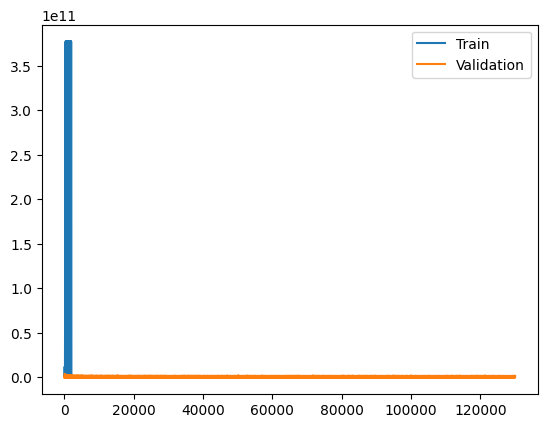

In [453]:
plt.plot(loss_train,label="Train")
plt.plot(val_losses, label="Validation")
plt.legend()

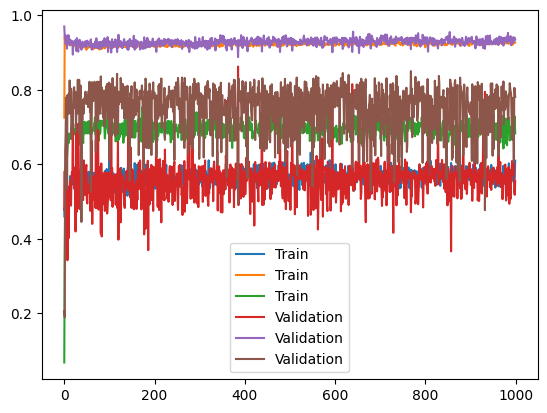

In [454]:
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Validation")
plt.legend()

In [455]:
train_accuracies_mean = [tensor.mean().item() for tensor in train_accuracies]
val_accuracies_mean = [tensor.mean().item() for tensor in val_accuracies]

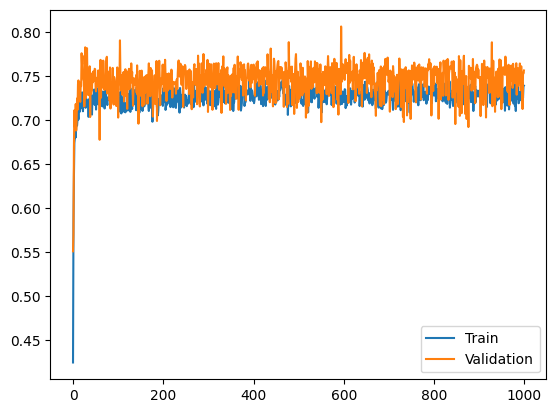

In [456]:
plt.plot(train_accuracies_mean, label="Train")
plt.plot(val_accuracies_mean, label="Validation")
plt.legend()